In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def set_device():
	global DEVICE
	if torch.cuda.is_available(): DEVICE = torch.device('cuda')
	else: DEVICE = torch.device('cpu')
	return DEVICE

DEVICE = set_device()

# Leitura de Dados

In [3]:
def input_to_pandas(ler, escrever, save = True):
	# Precisa ter a pasta original_files
	from io import StringIO

	with open(ler, 'r') as file:
		# Grab everything and then change to csv
		everything = file.read().strip()
		everything = everything.replace('(', '').replace(')', '').replace(' can0','').replace('#', ' ')
		everything = everything.replace(' ', ',')
		# read in csv
		frame = pd.read_csv(StringIO(everything), header=None)
		frame = frame.rename(columns = {0:'TIME', 1: 'ID', 2: 'DATA', 3: 'NORMAL'})
		
		# Changing R and T's
		mask_t = frame['NORMAL'] == 'T'; mask_r = frame['NORMAL'] == 'R'
		frame.loc[mask_r, 'NORMAL'] = True; frame.loc[mask_t, 'NORMAL'] = False;

		# Putting numbers instead of hexadecimal
		frame['DATA'] = frame['DATA'].apply(lambda x: int(x, 16))

		if save: frame.to_csv(escrever, index=False, header = True)
		frame = None # Fechando o frame para salvar memória

# input_to_pandas(r'3-impersonation-candump-2024-07-10_182049.log', '01impersonate.csv')


In [4]:
U_MISS = ['000', '007', '008', '00D', '00E', '014', '015', '016', '017', '041', '055', '056', '05B', '05C', '05D']
# UNIQUE = ['000', '007', '008', '00D', '00E', '014', '015', '016', '017', '041', '055', '056', '05B', '05C', '05D', 'NO']
SET = {'000', '007', '008', '00D', '00E', '014', '015', '016', 
			'017', '041', '055', '056', '05B', '05C', '05D'}

def one_hot_encoded(values):
	# Todos os outros vão em NO
	dummies = pd.get_dummies([x if x in SET else '000' for x in values], dtype=np.float32)
	return dummies.reindex(columns=U_MISS, fill_value=0.0)

def get_information(frame : pd.DataFrame):
	hot = one_hot_encoded(frame['ID'].values)
	# data_values = frame['DATA'].values
	# for x in range(len(hot)):
	# 	y = hot.iloc[x].idxmax()
	# 	hot.at[x,y] = data_values[x].astype(np.float32)
	
	# hot['DATA'] = [x for x in frame['DATA'].values]
	hot = torch.tensor(hot.values, dtype=torch.float32).transpose(0,1)

	
	
	tipos = all(frame['NORMAL'].values) * 1.0 # Vê se tem um ataque
	tipos = torch.tensor([tipos], dtype=torch.float32)

	return hot, tipos

file_name = r'training\dos.csv'
file = pd.read_csv(file_name)
get_information(file.iloc[0:5])

(tensor([[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]),
 tensor([0.]))

In [5]:
class Dataset():
	def __init__(self, window, datas : list, division = 0.8):
		self.window_size = window
		self.datasets = []
		for i in datas:
			self.datasets.append(pd.read_csv(i))
		self.middle = []
		for i in self.datasets:
			self.middle.append(int(division * (len(i) // window)) - self.window_size)
		self.end = []
		for i in self.datasets:
			self.end.append((len(i) // window) - self.window_size)

	def __getitem__(self, place):
		table, index = place
		index *= self.window_size # offset
		frame = self.datasets[table][index : index + self.window_size]

		# Pegar informações
		return get_information(frame)
	
LISTA_TREINAMENTO = [r"training\normal.csv", r"training\dos.csv", r"training\false.csv", r"training\fuzz.csv", r"training\impersonate.csv", ]
dataset = Dataset(16, LISTA_TREINAMENTO)

In [6]:
class Dataloader():
	def __init__(self, dataset):
		self.dataset = dataset
		self.iter_t = [0,0,0,0,0] #normal, dos, false, fuzz, impersonate

	def reset_others(self, training = False):
		if training: self.iter_t[0] = 0
		self.iter_t[1] = 0
		self.iter_t[2] = 0
		self.iter_t[3] = 0
		self.iter_t[4] = 0
		
	def get_training(self, normal = 16, ataque = 4):
		# Pegar em valor 3 de cada		
		while True:
			values = []
			# Pegar os valores
			values += [self.dataset[0, x] for x in range(self.iter_t[0], self.iter_t[0] + normal)]
			values += [self.dataset[y, x] for y in [1,2,3,4] for x in range(self.iter_t[y], self.iter_t[y] + ataque) ]
			# Offset de iteradores
			self.iter_t[0] = self.iter_t[0] + normal if self.iter_t[0] + normal < self.dataset.middle[0] else 0
			
			sair = False
			for i in [1,2,3,4]:
				if self.iter_t[i] + ataque < self.dataset.middle[i]:
					self.iter_t[i] = self.iter_t[i] + ataque
				else: sair = True
			if sair: break
			
			# separar data e label
			data, label = zip(*values)
			yield torch.stack(data), torch.stack(label)
	
	def get_impersonate(self):
		# Pegar em valor 3 de cada		
		while True:
			values = []
			# Pegar os valores
			values += [self.dataset[0, x] for x in range(self.iter_t[0], self.iter_t[0] + 16)]
			values += [self.dataset[4, x] for x in range(self.iter_t[4], self.iter_t[4] + 16) ]
			# Offset de iteradores
			self.iter_t[0] = self.iter_t[0] + 16 if self.iter_t[0] + 16 < self.dataset.middle[0] else 0
			self.iter_t[4] = self.iter_t[4] + 16 if self.iter_t[4] + 16 < self.dataset.middle[4] else 0
						
			# separar data e label
			data, label = zip(*values)
			yield torch.stack(data), torch.stack(label)

	def get_validation(self):
		# Pegar em valor 3 de cada
		for i in range(5):
			values = [self.dataset[i, x] for x in 
				range(self.dataset.middle[i], self.dataset.end[i], self.dataset.window_size)]
			data, label = zip(*values)
			yield torch.stack(data), torch.stack(label)


dataloader = Dataloader(dataset)

# Criação de Modelo

In [7]:
def init_weigh_normal(model):
	for layer in model:
		if isinstance(layer, nn.Conv1d):
			nn.init.kaiming_normal_(layer.weight, nonlinearity="leaky_relu")
		if isinstance(layer, nn.BatchNorm1d):
			nn.init.ones_(layer.weight)
			nn.init.zeros_(layer.bias)
		if isinstance(layer, nn.BatchNorm2d):
			nn.init.ones_(layer.weight)
			nn.init.zeros_(layer.bias)

class Discriminator(nn.Module):
	def __init__(self, window):
		super(Discriminator, self).__init__()
		self.window = window

		self.convolutions = nn.Sequential(
			# 11,1,5 ou 13,1,6 ou 15,1,7 ou 17,1,8
			nn.Conv1d(15,9, 17, 1, 8, bias=False),
			nn.BatchNorm1d(9),
			nn.LeakyReLU(0.2, inplace=True),
			# Proxima camada
			nn.Conv1d(9,5, 17, 1, 8, bias=False),
			nn.BatchNorm1d(5),
			nn.LeakyReLU(0.2, inplace=True),
			# Proxima camada
			nn.Conv1d(5,3, 17, 1, 8, bias=False),
			nn.BatchNorm1d(3),
			nn.LeakyReLU(0.2, inplace=True),
		)
		
		init_weigh_normal(self.convolutions) # Para melhorar Talvez

		self.fullyConnected = nn.Sequential(
			nn.Linear(window * 3, window * 2),
			nn.BatchNorm1d(window * 2),
			nn.LeakyReLU(0.2, inplace=True),
			# Proxima camada
			nn.Linear(window * 2, 1),
			nn.Sigmoid()
		)

		init_weigh_normal(self.fullyConnected)

	def forward(self, x):
		y = self.convolutions(x)
		# print(y.shape)
		y = y.reshape(y.shape[0], -1)
		return self.fullyConnected(y)
	
# model = Discriminator(16).to(DEVICE)

# Treinamento

In [8]:
def graph_validation(model, dataloader : Dataloader, DEVICE, graph_range = (0,1)):
	model.eval()
	attack = []
	normal = []
	total = 0
	# Pegar os pontos
	for data, labels  in dataloader.get_validation():
		predictions = model(data.to(DEVICE))
		for label, prediction in zip(labels, predictions):
			if label.item() == 1.0: normal.append(prediction.item())
			else: attack.append(prediction.item())
			total += 1
	
	# Fazer os graficos
	plt.hist(normal, bins = 100, color='b', alpha = 0.4, range = graph_range)
	plt.hist(attack, bins = 100, color='r', alpha = 0.7, range = graph_range)	
	

In [9]:
def save_model(model, nome):
	torch.save(model.cpu(), f"{nome}")

def load_model(arquivo : Discriminator, window, device='cpu'):
	# Precisa ser da mesma janela
	model = Discriminator(window)
	model = torch.load(arquivo).to(device)
	criterion = nn.BCELoss() # Usado para regressão logística
	optmizer = torch.optim.SGD(model.parameters(), lr=2e-4, momentum=0.9) # Precisa ter um grande número de épocas para servir
	return model, criterion, optmizer

In [10]:
LISTA_TREINAMENTO = [r"training\normal.csv", r"training\dos.csv", r"training\false.csv", r"training\fuzz.csv", r"training\impersonate.csv"]

def create_everything(window, device = 'cpu', Adam = False, division = 0.8):
	model = Discriminator(window).to(device)
	criterion = nn.BCELoss()
	# OTIMO 2e-4 para lr
	# Momentum de 0.9 normal
	# Weight_decay com 1e-5
	if Adam: optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # Valores pegos de exemplo
	else:  optimizer = torch.optim.SGD(model.parameters(), lr = 2e-4, momentum=0.9, weight_decay=1e-3) # Só testar
	dataset = Dataset(window, LISTA_TREINAMENTO, division)
	dataloader = Dataloader(dataset)

	return model, criterion, optimizer, dataset, dataloader

In [11]:
def training(model, criterion, optmizer, dataloader : Dataloader, device, LIMIT = 0.05, EPOCHS = 1):
	training_losses = []
	validation_losses = []
	loss_training = 100
	loss_validation = 100
	sair = False
	TEST_VALIDATION = 16 * (128 / model.window)

	for epoch in range(EPOCHS):
		dataloader.reset_others()
		for iteration, (data,labels) in enumerate(dataloader.get_impersonate()):
			model.train()
			optmizer.zero_grad() # Zeroing gradients
			prediction = model(data.to(device))
			
			#Compute loss
			loss = criterion(prediction, labels.to(device))
			loss.backward()
			optmizer.step()
			
			training_losses.append(loss.detach().cpu().numpy())
			if (iteration + 1) % TEST_VALIDATION == 0:
				model.eval()
				for data, labels  in dataloader.get_validation():
					prediction = model(data.to(device))
					# Compute loss
					loss = criterion(prediction, labels.to(device))
					# salvando loss
					validation_losses.append(loss.detach().cpu().numpy())
				
				loss_training = np.mean(training_losses) 
				loss_validation = np.mean(validation_losses)
				print(f"[{epoch + 1}° Epoch] | {iteration + 1}° batch: Training loss = {loss_training : .6f} | Validation loss = {loss_validation : .5f}")
				
				training_losses.clear(); validation_losses.clear()
			
				if loss_validation < LIMIT or loss_training < LIMIT: 
					sair = True
					print("Saiu porque atingiu o limite")
					break
		
		if sair: break # Acabar
		
	print("Terminou o treinamento")

# Testes

In [12]:
model, criterion, optimizer, dataset, dataloader = create_everything(64, DEVICE, division = 0.9)
training(model, criterion, optimizer, dataloader, DEVICE, LIMIT = 0.01, EPOCHS=4)

[1° Epoch] | 32° batch: Training loss =  0.736766 | Validation loss =  0.81209
[1° Epoch] | 64° batch: Training loss =  0.733547 | Validation loss =  0.81230
[1° Epoch] | 96° batch: Training loss =  0.706787 | Validation loss =  0.78565
[1° Epoch] | 128° batch: Training loss =  0.688558 | Validation loss =  0.77354
[1° Epoch] | 160° batch: Training loss =  0.681571 | Validation loss =  0.75596
[1° Epoch] | 192° batch: Training loss =  0.664343 | Validation loss =  0.74867
[1° Epoch] | 224° batch: Training loss =  0.647975 | Validation loss =  0.71519
[1° Epoch] | 256° batch: Training loss =  0.614673 | Validation loss =  0.70332
[1° Epoch] | 288° batch: Training loss =  0.574068 | Validation loss =  0.67526
[1° Epoch] | 320° batch: Training loss =  0.529150 | Validation loss =  0.66187
[1° Epoch] | 352° batch: Training loss =  0.462379 | Validation loss =  0.64351
[1° Epoch] | 384° batch: Training loss =  0.386840 | Validation loss =  0.63709
[1° Epoch] | 416° batch: Training loss =  0

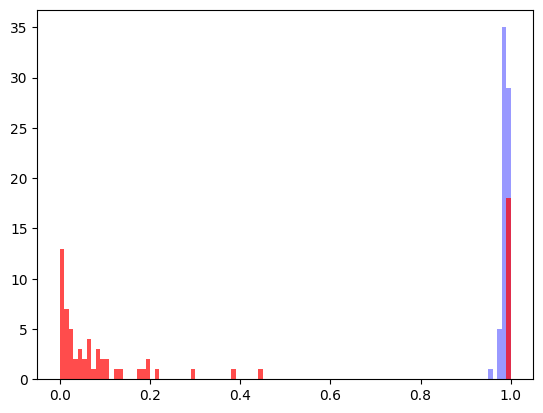

In [13]:
graph_validation(model, dataloader, DEVICE)

In [14]:
# model, _, _ = load_model('modelo_cnn64_simple_91.pth', 64, DEVICE)

In [15]:
def testing(model, path_to_files, window, limit = 0.5, device = 'cpu'):
	positivo, negativo, falso_positivo, falso_negativo = 0,0,0,0
	hits, total = 0,0
	model.eval()
	normal = []
	attack = [[],[],[],[]]

	# Começar a checar
	for dirpath, dirname, filenames in os.walk(path_to_files):
		print("Entrou em ", dirpath)
		for i, filename in enumerate(filenames):
			cur_hit, cur_total = 0,0
			if i != 3: 	print(f"{filename} \t\t ", end = "")
			else: 		print(f"{filename} \t ", end = "") # Impersonate
			# Lendo arquivo
			frame = pd.read_csv(f"{os.path.join(dirpath, filename)}")
			separar = [frame[i : i + window] for i in range(0, len(frame) - (len(frame) % window), window)]
			data, label = zip(*[get_information(x) for x in separar])
			# Predict
			result = model(torch.stack(data).to(device))
			# label = torch.stack(label)
			for x, y in zip(result, label):
				r, l = x.item(), y.item()
				# Checar valores
				if 	 (r >= limit and l == 1.0): positivo += 1; hits += 1; cur_hit += 1
				elif (r < limit and l == 0.0): negativo += 1; hits += 1; cur_hit += 1
				elif (r >= limit and l == 0.0): falso_positivo += 1
				elif (r < limit and l == 1.0): falso_negativo += 1
				total += 1; cur_total += 1
				# Colocar nos valores
				if l == 1.0: normal.append(r)
				else: attack[i].append(r)
			print(f"Acurácia {cur_hit/cur_total * 100}% | Total: {hits/total * 100}%")
	# Retornando
	if total: return hits/total, hits, total, [normal] + attack, [positivo, falso_positivo, falso_negativo, negativo] # Porcentagem de certo

acc, acert, total, graphs, confusion_matrix = testing(model, 'tests', 64, device = DEVICE)
print(f"Acurácia total {acc * 100}%")

Entrou em  tests
Entrou em  tests\grupo0
01dos.csv 		 Acurácia 61.39817629179332% | Total: 61.39817629179332%
02false.csv 		 Acurácia 63.6963696369637% | Total: 62.5%
03fuzz.csv 		 Acurácia 94.83985765124555% | Total: 72.45345016429354%
04impersonate.csv 	 Acurácia 68.0140597539543% | Total: 71.39874739039665%
Entrou em  tests\grupo1
11dos.csv 		 Acurácia 64.84848484848484% | Total: 69.98363338788872%
12false.csv 		 Acurácia 63.934426229508205% | Total: 68.9768076398363%
13fuzz.csv 		 Acurácia 94.84902309058614% | Total: 72.42194891201514%
14impersonate.csv 	 Acurácia 67.95096322241682% | Total: 71.88997707855803%
Entrou em  tests\grupo2
21dos.csv 		 Acurácia 64.18816388467374% | Total: 70.96005862953463%
22false.csv 		 Acurácia 63.81578947368421% | Total: 70.24398285525882%
23fuzz.csv 		 Acurácia 94.84902309058614% | Total: 72.3336853220697%
24impersonate.csv 	 Acurácia 68.24561403508773% | Total: 72.01000138908181%
Acurácia total 72.01000138908181%


Positivo: 0.71 		| Falso Positivo: 0.28
Falso Negativo: 0.00 	| Negativo: 0.01


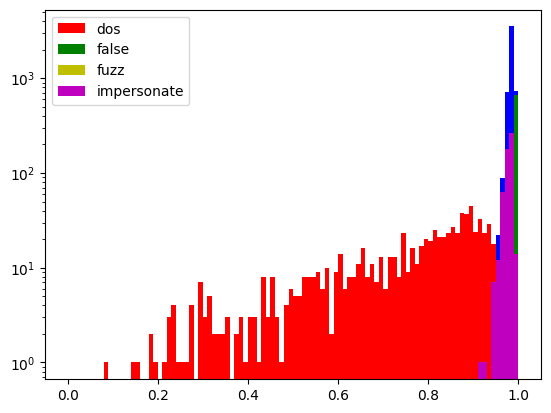

In [16]:
def make_graph(datas, confusion_matrix, graph_range = (0,1)):
	total = sum(confusion_matrix)
	print(f"Positivo: {confusion_matrix[0]/total :.2f} \t\t| Falso Positivo: {confusion_matrix[1]/total :.2f}")
	print(f"Falso Negativo: {confusion_matrix[2]/total :.2f} \t| Negativo: {confusion_matrix[3]/total :.2f}")

	# Fazendo gráfico
	plt.hist(datas[0], bins = 100, color='b',  range = graph_range)
	plt.hist(datas[1], bins = 100, color='r',  range = graph_range, label='dos')	
	plt.hist(datas[2], bins = 100, color='g',  range = graph_range, label='false')	
	plt.hist(datas[3], bins = 100, color='y',  range = graph_range, label='fuzz')	
	plt.hist(datas[4], bins = 100, color='m',  range = graph_range, label='impersonate')	
	plt.legend(); plt.yscale('log')

make_graph(graphs, confusion_matrix)

In [17]:
# save_model(model, 'modelo_cnn64_91.pth')

In [18]:
# model, criterion, optimizer = load_model('modelo_cnn32.pth', 32, DEVICE)